In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt

In [3]:
# Load the California Housing dataset
california = fetch_california_housing()
X = california.data
y = california.target
data = pd.DataFrame(X, columns=california.feature_names)
data['PRICE'] = y

# Explore the dataset
print("Dataset Size:", data.shape)
print("\nFeature Names:", california.feature_names)
print("\nFirst 5 rows:\n", data.head())

Dataset Size: (20640, 9)

Feature Names: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']

First 5 rows:
    MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  PRICE  
0    -122.23  4.526  
1    -122.22  3.585  
2    -122.24  3.521  
3    -122.25  3.413  
4    -122.25  3.422  


In [4]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
# Convert to DMatrix
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)

In [7]:
# Train initial model
default_params = {
    'objective': 'reg:squarederror', 'max_depth': 3, 'eta': 0.1,
    'subsample': 0.8, 'colsample_bytree': 0.8, 'eval_metric': 'rmse', 'seed': 42
}
num_rounds = 100

In [8]:
initial_model = xgb.train(default_params, dtrain, num_rounds)

In [9]:
# Evaluate initial model
y_pred_initial = initial_model.predict(dtest)
mse_initial = mean_squared_error(y_test, y_pred_initial)
r2_initial = r2_score(y_test, y_pred_initial)
print("Basic Model Mean Squared Error:", mse_initial)
print("Basic Model R² Score:", r2_initial)

Basic Model Mean Squared Error: 0.28851653534824134
Basic Model R² Score: 0.7798271073084774


In [11]:
# Hyperparameter tuning with GridSearchCV
tuning_options = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.3, 0.5]
}

In [12]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', subsample=0.8, colsample_bytree=0.8, eval_metric='rmse', seed=42)

In [13]:
grid_search = GridSearchCV(estimator=xgb_model, param_grid=tuning_options, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

In [14]:
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    device=None, early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None,...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.3, 0.5],
                         'max_depth': [3, 5, 7]},
             scoring='neg_mean_squared_error')

In [15]:
best_params = grid_search.best_params_
print("Best Settings:", best_params)

Best Settings: {'learning_rate': 0.1, 'max_depth': 7}


In [16]:
# Convert settings for DMatrix training
train_params = {
    'objective': 'reg:squarederror', 'max_depth': best_params['max_depth'],
    'eta': best_params['learning_rate'], 'subsample': 0.8, 'colsample_bytree': 0.8,
    'eval_metric': 'rmse', 'seed': 42
}
num_rounds = 100

In [17]:
# Retrain with best settings
tuned_model = xgb.train(train_params, dtrain, num_boost_round=num_rounds)

In [18]:
# Evaluate tuned model
y_pred_tuned = tuned_model.predict(dtest)
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)
print("Tuned Model Mean Squared Error:", mse_tuned)
print("Tuned Model R² Score:", r2_tuned)

Tuned Model Mean Squared Error: 0.2106159392876334
Tuned Model R² Score: 0.8392746518187281


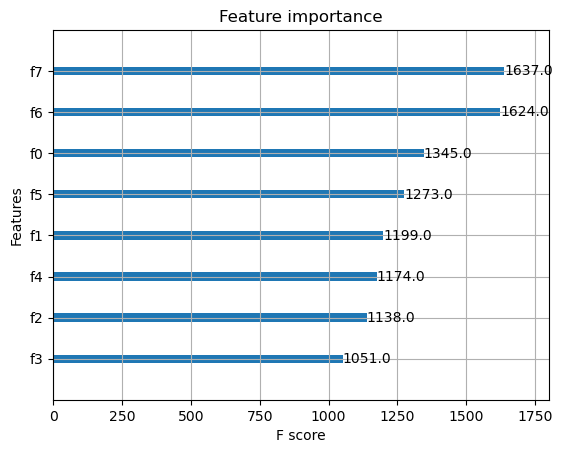

In [19]:
# Visualize feature importance
xgb.plot_importance(tuned_model)
plt.show()